###  Imports

In [13]:
item_list = ['flag', 'person', 'helmet', 'astronaut', 'space shuttle', 'camera', 'train', 'helicopter', 'army tank']
image_dir = r'./test_images'

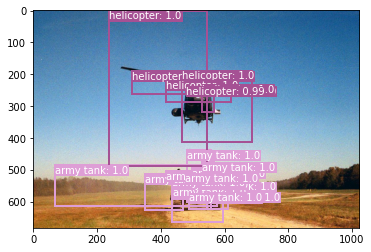

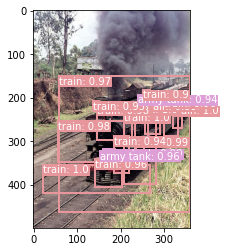

In [14]:
from evaluation import eval
#args:
#     rpn_score_thresh = minimum threshold objectness score. default: 0.05
#     iou_thresh = minimum overlap to be considered the same object. default: 0.2
#     conf_thresh = minimum classification confidence. default: 0.9
#     item_list = list of classes
#     MODEL_EPOCH = epoch of trained model
eval(item_list, image_dir=image_dir)